## TODO

revise get clusters names

revise get accuracy , and think what will happen if missing cluster names
report both models results on some samples from test data
<br>

modify dataset perc to use

<br>

# **Milestone 2**

### Packages installation

In [193]:
!pip install kagglehub
!pip install imagehash
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
print("done installing packages")


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
done installing packages


### imports

In [194]:
import os
import kagglehub
import random
from PIL import Image
import imagehash
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.decomposition import PCA
from time import time

print("done importing packages")


done importing packages


## **Data preparaion**

### Dataset path

In [195]:
if 'COLAB_GPU' in os.environ:
    dataset_folder = kagglehub.dataset_download('hussainghoraba/emotions-dataset')
    DATASET_PATH = os.path.join(dataset_folder, 'Dataset')
elif 'KAGGLE_URL_BASE' in os.environ:
    DATASET_PATH = '/kaggle/input/emotions-dataset/Dataset'
elif 'VSCODE_PID' in os.environ:
    DATASET_PATH = './Dataset'
else:
    raise Exception('Unknown environment')

print("done setting up dataset path")

done setting up dataset path


### Set random seed & some global variables

In [196]:
RANDOM_SEED = 42
TAREGT_SIZE_TUPLE = (512, 512)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
print("done setting up random seed")

done setting up random seed


### Functions

In [197]:
def calculate_and_print_time(start_time, section_name):
    end_time = time()
    time_taken = end_time - start_time
    hours = int(time_taken // 3600)
    minutes = int((time_taken % 3600) // 60)
    seconds = int((time_taken % 3600) % 60)
    print(f'\n{section_name} Done in : {hours} h, {minutes} m, {seconds} s')
    
def extend_depth(filters, depth):
    return np.stack([filters] * depth, axis=-1)

def get_image_flattened_windows(input_data, filter_size):
    input_h, input_w, input_c = input_data.shape
    output_h = input_h - filter_size + 1
    output_w = input_w - filter_size + 1

    col = np.zeros((output_h * output_w, filter_size * filter_size * input_c))
    i = 0
    for h in range(output_h):
        for w in range(output_w):
            cube = input_data[h:h+filter_size, w:w+filter_size, :]
            col[i, :] = cube.flatten()
            i += 1
    return col

def downsample_features(features_arrays):
    # downsample the features arrays to only 128 dimensions
    # use PCA only if we have more than 128 feature arrays ,
    # this is because in PCA, the number of components (which is 128 in our case) 
    # must be less than the number of samples.
    # if we have less than 128 feature arrays, we will just select random 128 features
    if features_arrays.shape[0] >= 128:
        print(f"appling PCA...")
        features_arrays = PCA(n_components=128).fit_transform(features_arrays)
    else:
        print(f"selecting random 128 features from {features_arrays.shape[0]} features")
        selected_indices = np.random.choice(features_arrays.shape[1], 128, replace=False)
        features_arrays = features_arrays[:, selected_indices]
    return features_arrays

def extract_features(model, df):
    start_time = time()
    num_features = model.layers[-1].output_shape[0]
    features_arrays = np.zeros((len(df), num_features))

    with tqdm(total=len(df), desc="Extracting features...") as pbar:
        for i in range(len(df)):
            img_arr = df.iloc[i]['img_arr']
            features_arrays[i, :] = model.forward(img_arr)
            pbar.update(1)
    calculate_and_print_time(start_time, "Feature Extraction without downsampling")
    return downsample_features(features_arrays)

def calculate_accuracy(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    correct_predictions = np.sum(true_labels == predicted_labels)
    accuracy = correct_predictions / len(true_labels)
    return accuracy


### Load dataset into memory without dups, and with correct size, and equalize the number of images in each class


In [198]:
global_start_time = time()
total_images_count = sum(len(files) for _, _, files in os.walk(DATASET_PATH))
print(f"Total images in dataset: {total_images_count}")
train_features_arrays = []
dups_pairs = set()

# load only a small percentage of the dataset, for faster testing while developing
DATASET_PERC_TO_USE = 0.1
  
num_images_in_smallest_category = min(len(os.listdir(os.path.join(DATASET_PATH, folder))) for folder in os.listdir(DATASET_PATH))
num_of_images_to_use_in_each_category = int(num_images_in_smallest_category * DATASET_PERC_TO_USE)
num_of_categories = len(os.listdir(DATASET_PATH))
total_images_to_load = int(num_images_in_smallest_category * num_of_categories * DATASET_PERC_TO_USE)

with tqdm(total=total_images_to_load, desc="Loading images into memory...") as pbar:
    for subfolder in os.listdir(DATASET_PATH):
        subfolder_path = os.path.join(DATASET_PATH, subfolder)
        subfolder_hashes = {}

        all_category_images = os.listdir(subfolder_path)
        # we must use the same number of images from each category to avoid bias
        images_to_load = random.sample(all_category_images, num_of_images_to_use_in_each_category)
        
        for img_file in images_to_load:
            img_path = os.path.join(subfolder_path, img_file)
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(TAREGT_SIZE_TUPLE)
                img_arr = np.array(img)
                img_hash = imagehash.phash(img)
            if img_hash not in subfolder_hashes.keys():
                train_features_arrays.append({"img_path": img_path, "label": subfolder, "img_arr": img_arr})
                # key : hash, value : img_path
                subfolder_hashes[img_hash] = img_path
            else:
                existing_duplicate = subfolder_hashes[img_hash]
                dups_pairs.add((img_path, existing_duplicate))
            pbar.update(1)
        
df = pd.DataFrame(train_features_arrays)

# display dups
for dup_pair in dups_pairs:
    print(f"Duplicate images found: {dup_pair[0]} and {dup_pair[1]}")
    img1 = Image.open(dup_pair[0])
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(os.path.basename(dup_pair[0]))
    plt.axis('off')
    img2 = Image.open(dup_pair[1])
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(os.path.basename(dup_pair[1]))
    plt.axis('off')
    plt.show()
calculate_and_print_time(global_start_time, "Loading images into memory")

Total images in dataset: 2125


Loading images into memory...:  98%|█████████▊| 116/118 [00:01<00:00, 82.89it/s]


Loading images into memory Done in : 0 h, 0 m, 1 s


### Train/Test/Val split

In [199]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), stratify=df['label'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (test_ratio + val_ratio)), stratify=temp_df['label'], random_state=RANDOM_SEED)

# Print the sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\ntraining set:")
print(train_df['label'].value_counts())

print("\nvalidation set:")
print(val_df['label'].value_counts())

print("\ntest set:")
print(test_df['label'].value_counts())


print("done splitting dataset into train, val, test")

Training set size: 81
Validation set size: 23
Test set size: 12

training set:
label
Happy      21
Sad        20
Neutral    20
Angry      20
Name: count, dtype: int64

validation set:
label
Sad        6
Neutral    6
Angry      6
Happy      5
Name: count, dtype: int64

test set:
label
Neutral    3
Happy      3
Sad        3
Angry      3
Name: count, dtype: int64
done splitting dataset into train, val, test


## **Model 1**

### Classes & Functions

In [200]:
class ConvLayer:
    def __init__(self, filter_size=3, num_filters=5, filter_weights=None):
        self.filter_size = filter_size
        self.num_filters = num_filters
        if filter_weights is None:
            filter_weights = np.random.normal(size=(num_filters, filter_size, filter_size)) * 0.1
        self.filter_weights = filter_weights

        self.input_shape = None
        self.output_shape = None
        self.deep_filters = None
        self.deep_filters_shape = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        input_h, input_w, input_c = input_shape

        # ------------------- define the output shape 
        output_h = input_h - self.filter_size + 1
        output_w = input_w - self.filter_size + 1
        self.output_shape = (output_h, output_w, self.num_filters)

        # ------------------- initilize deep filters 
        #  extend the filter weights depth so that filter depth = input depth (input channels)
        self.deep_filters = extend_depth(self.filter_weights, input_c)
        self.deep_filters_shape = self.deep_filters.shape
        # flatten the filters for fast matrix multiplication in the "forward" fuction
        self.deep_filters = self.deep_filters.reshape(self.num_filters, -1)


    def forward(self, input_image):
        output_h, output_w = self.output_shape[0], self.output_shape[1]
        input_col = get_image_flattened_windows(input_image, self.filter_size)
        output_flat = self.deep_filters @ input_col.T
        output = output_flat.T.reshape(output_h, output_w, self.num_filters)
        return output
    

class PoolingLayer:
    def __init__(self, pool_size=2, pool_type='MAX'):
        if pool_type not in ['MAX', 'AVERAGE']:
            raise ValueError("pool_type must be either 'MAX' or 'AVERAGE'")
        self.pool_size = pool_size
        self.pool_type = pool_type

        self.input_shape = None
        self.output_shape = None
        self.output = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        input_h, input_w, input_c = input_shape

        # define the output shape
        output_h = input_h // self.pool_size
        output_w = input_w // self.pool_size
        self.output_shape = (output_h, output_w, input_c)

        # initialize the output array
        self.output = np.zeros(self.output_shape)

    def forward(self, input_image):
        for i in range(self.output.shape[0]):
            for j in range(self.output.shape[1]):
                h_start = i * self.pool_size
                h_end = h_start + self.pool_size
                w_start = j * self.pool_size
                w_end = w_start + self.pool_size

                pool_window = input_image[h_start:h_end, w_start:w_end, :]

                if self.pool_type == 'MAX':
                    self.output[i, j, :] = np.max(pool_window, axis=(0, 1))
                elif self.pool_type == 'AVERAGE':
                    self.output[i, j, :] = np.mean(pool_window, axis=(0, 1))

        # apply relu
        return np.maximum(0, self.output)
    
class FlatteningLayer:
    def __init__(self):
        self.input_shape = None
        self.output_shape = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = (input_shape[0] * input_shape[1] * input_shape[2],)

    def forward(self, input_image):
        return input_image.flatten()


class Model_1:
    def __init__(self, layers, first_layer_input_shape):
        self.layers = layers

        # Set the input shape for each layer based on the output shape of the previous layer
        previous_layer_shape = first_layer_input_shape
        for layer in self.layers:
            layer.set_input_shape(previous_layer_shape)
            previous_layer_shape = layer.output_shape  

    def visualize_architecture(self):
        print("Model architecture : 🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️\n")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i + 1}: {layer.__class__.__name__}")
            print(f"Input shape: {layer.input_shape}")
            print(f"Output shape: {layer.output_shape}")
            if isinstance(layer, ConvLayer):
                print(f"Number of filters: {layer.deep_filters_shape[0]}")
                print(f"Filter Shape: {layer.deep_filters_shape[-3:]}")
            elif isinstance(layer, PoolingLayer):
                print(f"Pooling size: {layer.pool_size}")
                print(f"Pooling type: {layer.pool_type}")
            print("-" * 30)

    def forward(self, input_image):
        output = input_image
        for layer in self.layers:
            output = layer.forward(output)
        return output

class Custom_Kmeans:
    def __init__(self, k):
        self.k = k
        self.centroids = None
        self.clusters_names = None
        self.index_labels = None

    def predict(self, feature_arr):
        distances = np.linalg.norm(feature_arr - self.centroids, axis=1)
        cluster_index = np.argmin(distances)

        # replace every index label with the name of the centroid, put in a new array
        # exmaple : convert [0, 1, 2, 3] to ['happy', 'sad', 'angry', 'neutral']
        return self.clusters_names[cluster_index]
    
    def get_clusters_names(self, true_labels):
        num_of_classes = len(np.unique(true_labels))
        cluster_names = []
        for i in range(num_of_classes):
            cluster_labels = true_labels[self.index_labels == i]
            most_common_label = pd.Series(cluster_labels).mode()[0]
            cluster_names.append(most_common_label)
        return np.array(cluster_names)
    
    def fit(self, train_features_arrays, train_features_arrays_labels, val_features_arrays, val_features_arrays_labels):
        # features_arrays is a 2D array of shape (num_images, num_features)
        # features_arrays_labels is a 1D array of shape (num_samples,), 
        # representing the labels of images whose features are passed as features_arrays
        rows_count = train_features_arrays.shape[0]

        # Initialize centroids randomly    gg
        self.centroids = train_features_arrays[np.random.choice(rows_count, self.k, replace=False)]

        iterations_accuracies = []
        while True:
            distances = np.linalg.norm(train_features_arrays[:, np.newaxis] - self.centroids, axis=2)
            self.index_labels = np.argmin(distances, axis=1) 
            previous_centroids = self.centroids.copy()
            self.centroids = np.array([train_features_arrays[self.index_labels == i].mean(axis=0) for i in range(self.k)])
            
            # name each cluster as the name of the most frequent label in the cluster
            self.clusters_names = self.get_clusters_names(train_features_arrays_labels)

            # predict the labels of the validation set
            val_predicted_labels = np.array([self.predict(val_features_arrays[i]) for i in range(len(val_features_arrays))])

            # calculate the accuracy
            val_accuracy = calculate_accuracy(val_features_arrays_labels, val_predicted_labels)

            iterations_accuracies.append(val_accuracy)

            # breack if difference between new and old centroids is small
            tolerance = 1e-4
            if np.all(np.linalg.norm(self.centroids - previous_centroids, axis=1) < tolerance):
                break
        return iterations_accuracies


### Using the model to extract features

In [201]:
filter_weights = np.stack([
    np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
    np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
    np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
], axis=0)

model_1 = Model_1(
    layers=[
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        FlatteningLayer()
    ],
    first_layer_input_shape=df.iloc[0]['img_arr'].shape
)
model_1.visualize_architecture()


train_features_arrays = extract_features(model_1, train_df)
val_features_arrays = extract_features(model_1, val_df)

Model architecture : 🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

Layer 1: ConvLayer
Input shape: (512, 512, 3)
Output shape: (510, 510, 5)
Number of filters: 5
Filter Shape: (3, 3, 3)
------------------------------
Layer 2: PoolingLayer
Input shape: (510, 510, 5)
Output shape: (255, 255, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 3: ConvLayer
Input shape: (255, 255, 5)
Output shape: (253, 253, 5)
Number of filters: 5
Filter Shape: (3, 3, 5)
------------------------------
Layer 4: PoolingLayer
Input shape: (253, 253, 5)
Output shape: (126, 126, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 5: FlatteningLayer
Input shape: (126, 126, 5)
Output shape: (79380,)
------------------------------


Extracting features...: 100%|██████████| 81/81 [01:08<00:00,  1.19it/s]



Feature Extraction without downsampling Done in : 0 h, 1 m, 8 s
selecting random 128 features from 81 features


Extracting features...: 100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


Feature Extraction without downsampling Done in : 0 h, 0 m, 19 s
selecting random 128 features from 23 features


### Clustering 

In [202]:
num_classes = len(df['label'].unique())
train_features_arrays_labels = train_df['label'].values
val_features_arrays_labels = val_df['label'].values

kmeans = Custom_Kmeans(k=num_classes)
clustering_val_accuracies_histroy = kmeans.fit(train_features_arrays, train_features_arrays_labels, val_features_arrays, val_features_arrays_labels)
print("Model 1 val accuracy: ", clustering_val_accuracies_histroy[-1])

# print the number of each class in each cluster
for i in range(num_classes):
    cluster_labels = train_features_arrays_labels[kmeans.index_labels == i]
    print(f"Cluster {i}:")
    print(pd.Series(cluster_labels).value_counts())
    print("-" * 30)

Model 1 val accuracy:  0.21739130434782608
Cluster 0:
Neutral    8
Angry      6
Sad        5
Happy      3
Name: count, dtype: int64
------------------------------
Cluster 1:
Sad        9
Happy      7
Angry      5
Neutral    2
Name: count, dtype: int64
------------------------------
Cluster 2:
Happy      4
Neutral    4
Angry      3
Sad        3
Name: count, dtype: int64
------------------------------
Cluster 3:
Happy      7
Angry      6
Neutral    6
Sad        3
Name: count, dtype: int64
------------------------------


### Testing model 1 on test data

In [203]:
test_features_arrays = extract_features(model_1, test_df)
test_features_arrays_labels = test_df['label'].values
test_predicted_labels = np.array([kmeans.predict(test_features_arrays[i]) for i in range(len(test_features_arrays))])
test_accuracy = calculate_accuracy(test_features_arrays_labels, test_predicted_labels)
print("Model 1 test accuracy: ", test_accuracy)

Extracting features...: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Feature Extraction without downsampling Done in : 0 h, 0 m, 10 s
selecting random 128 features from 12 features
Model 1 test accuracy:  0.25


## **Model 2**

In [204]:
# TA Dinah : "You should have 5 convolution blocks each with 3 layers.
#  3 convolution layers are simply 3 different filters on the same stage.
#  A convolution block is some conv filters (layers) followed by an activation function and then a max pooling. 
# All convolution filters in the same block need to have the same size."

def create_model2():
    model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(TAREGT_SIZE_TUPLE[0], TAREGT_SIZE_TUPLE[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    # 128 is OUR CHOICE for the number of neurons in the hidden layer (not specified in the project description)
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

model2 = create_model2()


print("done building model 2")

done building model 2


/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Early stopping to prevent overfitting (for the BONUS)

In [205]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

### Data augmentation (for the BONUS)

In [206]:
# thiss will rotate the images by up to 20 degrees, also will increase the 
# dataset size on the fly while training 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Model 2 training

In [207]:
# start_time = time()
# batch_size = 16
# epochs = 10

# # print trining dataset size before and after augmentation
# print(f"Training dataset size before augmentation: {len(train_df)}")
# train_gen = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     target_size=TAREGT_SIZE_TUPLE,
#     x_col='img_path',  
#     y_col='label',    
#     batch_size=batch_size,
#     class_mode='categorical', 
#     shuffle=True
# )
# print(f"Training dataset size after augmentation: {train_gen.n}")

# val_gen = val_datagen.flow_from_dataframe(
#     dataframe=val_df,
#     target_size=TAREGT_SIZE_TUPLE,
#     x_col='img_path',
#     y_col='label',
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )
# print(f"images sizes passed to image data generator: {train_gen.image_shape}")

# test_gen = test_datagen.flow_from_dataframe(
#     dataframe=test_df,
#     target_size=TAREGT_SIZE_TUPLE,
#     x_col='img_path',
#     y_col='label',
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False
# )


# model2_history = model2.fit(
#     train_gen,
#     validation_data=val_gen,
#     callbacks=[early_stoping, learning_rate_reduction],
#     epochs=epochs,
# )

# test_loss, test_acc = model2.evaluate(test_gen)
# print(f"Val accuracy: {model2_history.history['val_accuracy'][-1]:.2f}")
# print(f"Test accuracy: {test_acc:.2f}")


# calculate_and_print_time(start_time, "Training model 2")


### Displyaing samples inputs and outputs from both model 1 & model 2 (for the report)

## **model 1**


## **model 2**


# **Milestone 3**

## **model 1**


### Accuracy vs iterations


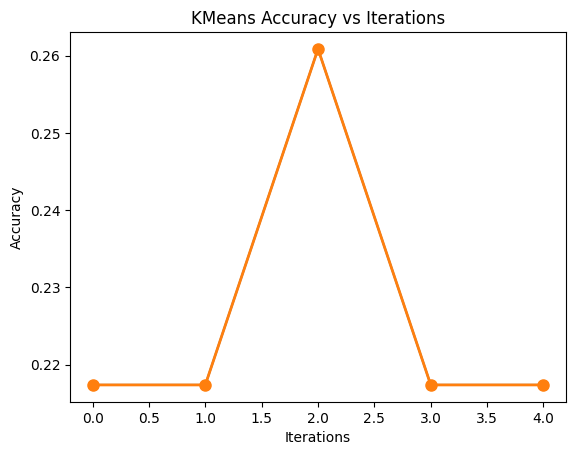

In [208]:
# plot accuracy vs iterations
plt.plot(clustering_val_accuracies_histroy)
plt.plot(clustering_val_accuracies_histroy, marker='o', markersize=8, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('KMeans Accuracy vs Iterations')
plt.show()

### K-fold cross-validation

In [209]:
# to be implemented

###  Confusion matrix

In [210]:
# to be implemented

## **model 2**


### Accuracy vs iterations


In [211]:
# plt.plot(model2_history.history['accuracy'], label='train accuracy')
# plt.plot(model2_history.history['val_accuracy'], label='val accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

### K-fold cross-validation

In [212]:
# start_time = time()
# k = 4
# kf = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

# fold_accuracies = []

# for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
#     print(f"\nStarting fold {fold + 1}/{k}...")
    
#     train_data = df.iloc[train_idx]
#     val_data = df.iloc[val_idx]
    
#     train_gen = train_datagen.flow_from_dataframe(
#         dataframe=train_data,
#         x_col='img_path',
#         y_col='label',
#         target_size=TAREGT_SIZE_TUPLE,
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=True
#     )
    
#     val_gen = val_datagen.flow_from_dataframe(
#         dataframe=val_data,
#         x_col='img_path',
#         y_col='label',
#         target_size=TAREGT_SIZE_TUPLE,
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=False
#     )
    
#     model2 = create_model2()
    
#     model2_history = model2.fit(
#         train_gen,
#         validation_data=val_gen,
#         callbacks=[early_stoping, learning_rate_reduction],
#         epochs=epochs,
#     )
    
#     val_accuracy = model2.evaluate(val_gen)[1]
#     print(f"\nFold {fold + 1} - Validation Accuracy: {val_accuracy:.4f}")
#     fold_accuracies.append(val_accuracy)


# average_accuracy = sum(fold_accuracies) / k
# print(f"All folds validation accuracies: {fold_accuracies}")
# print(f"Average Accuracy: {average_accuracy:.2f}")


# calculate_and_print_time(start_time, "Model 2 K-fold cross-validation")



###  Confusion matrix

In [213]:
# def display_confusion_matrix(model, val_gen, plt_title):
#     y_true = val_gen.classes
#     print(f"y_true : {y_true}")
#     y_pred = model.predict(val_gen)
#     # print(f"y_pred : {y_pred}")
#     y_pred_classes = y_pred.argmax(axis=1)
    
#     cm = confusion_matrix(y_true, y_pred_classes)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
#     disp.plot(cmap='viridis')
#     plt.title(plt_title)
#     plt.show()

# display_confusion_matrix(model2, val_gen, "Confusion Matrix for model 2")
# calculate_and_print_time(global_start_time, "All Notebook")


### notes : model2 problem is not in the model architecture (varified this by trying on bachelor model architecture, got similar results) so the problem is most likely in the data, or some where else in the code